# DeepDream

<img src="https://i.ibb.co/KstNsWZ/aus-5.jpg" width="900">

## Блоги и видосы
* https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html 
* https://en.wikipedia.org/wiki/DeepDream
* [Хороший пост с кодом](https://hackernoon.com/dl06-deepdream-with-code-5f735052e21f)
* [DeepDream Tensorflow, видос](https://youtu.be/ws-ZbiFV1Ms)

## Код
* [Понятный торчовый код {source}](https://github.com/duc0/deep-dream-in-pytorch)
* [Оригинальный код гугл на caffe](https://github.com/google/deepdream)


<img src="https://i.imgflip.com/20xebi.gif">

**Quiz: кто изображен на картинке?**

In [1]:
import torch
from torchvision import models, transforms
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

In [2]:
CUDA_ENABLED = False

# Конфиги тут

LAYER_ID = 28 # Номер слоя, активации которого хотим максимизировать
NUM_ITERATIONS = 5 # Количество итераций для обновления картинки градиентами слоя LAYER_ID
LR = 0.2 # learning rate

NUM_DOWNSCALES = 20 # количество раз, когда мы уменьшаем изображение
BLEND_ALPHA = 0.6 # чтобы хорошо мешать изображения

Для алгоритма DeepDream нам сойдет любая предобученная сверточная архитектура.

Мы воспользуемся VGG16, в оригинале использовали Inception.

### VGG16
<img src="https://www.altoros.com/blog/wp-content/uploads/2017/04/the-vgg16-model-architecture-tensorflow-keras.png" width="700">

In [3]:
# загрузим VGG и посмотрим на модули
vgg = models.vgg16(pretrained=True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/max/.torch/models/vgg16-397923af.pth
553433881it [03:04, 2994157.32it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [4]:
len(list(vgg.features.modules()))

32

## Что делает DeepDream?

### Представьте что теперь ваши параметры это сама картинка, а не слои в нейросети

Вам нужно сделать с вашей картинкой что-то такое, чтобы она была больше похожа на какой-то класс (например, на класс "собачки").

<img src="https://i.ibb.co/TK3zHvR/classvis-4x4.png" width="600">


**Базовый алгоритм DeepDream [кратко]**

* Берет картинку и прогоняет ее через все слои до слоя N
* Хотим, чтобы активации на слое N были большие
* Считает градиент этого слоя по отношению к входному изображению
* Прибавляем этот градиент к исходному изображению

**Quiz: зачем прибавлять градиент, а не вычитать градиент?**

<img src="http://i.imgur.com/ePEmb9U.gif">

In [5]:
class DeepDream:
    """ Объявляем базовые трансформации картинки """
    def __init__(self, image):
        self.image = image
        self.model = models.vgg16(pretrained=True)
        if CUDA_ENABLED:
            self.model = self.model.cuda()
        self.modules = list(self.model.features.modules())
        
        # vgg16 use 224x224 images
        imgSize = 224
        self.transformMean = [0.485, 0.456, 0.406]
        self.transformStd = [0.229, 0.224, 0.225]
        self.transformNormalise = transforms.Normalize(
            mean=self.transformMean,
            std=self.transformStd
        )
        
        self.transformPreprocess = transforms.Compose([
            transforms.Resize((imgSize, imgSize)),
            transforms.ToTensor(),
            self.transformNormalise
        ])
        
        self.tensorMean = torch.Tensor(self.transformMean)
        if CUDA_ENABLED:
            self.tensorMean = self.tensorMean.cuda()

        self.tensorStd = torch.Tensor(self.transformStd)
        if CUDA_ENABLED:
            self.tensorStd = self.tensorStd.cuda()

    def toImage(self, input):
        return input * self.tensorStd + self.tensorMean

In [6]:
class DeepDream(DeepDream):
    """ Добавим применение базового алгоритма к входной картинке """
    def deepDream(self, image, layer, iterations, lr):
        transformed = self.transformPreprocess(image).unsqueeze(0)
        if CUDA_ENABLED:
            transformed = transformed.cuda()
            
        input_img = torch.autograd.Variable(transformed, requires_grad=True)
        self.model.zero_grad()
        
        # iterations - это количество раз,
        # которое мы прогоняем картинку через все слои
        # до слоя layerId;
        # на каждой итерации при этом к картинке прибавляется градиент функции loss;
        # loss - это 
        for _ in range(iterations):
            out = input_img
            for layerId in range(layer):
                out = self.modules[layerId + 1](out)
            loss = out.norm()
            loss.backward()
            input_img.data = input_img.data + lr * input_img.grad.data

        input_img = input_img.data.squeeze()
        input_img.transpose_(0,1)
        input_img.transpose_(1,2)
        input_img = np.clip(self.toImage(input_img), 0, 1)
        input_img = np.clip(input_img, 0, 1)
        return Image.fromarray(np.uint8(input_img*255))

На самом деле базовый алгоритм применяется не всегда к исходному изображению, а применяется последовательно к разным масштабам входного изображения (смотри картинку).

---
**Quiz: зачем нужно скалировать изображение?**

<img src="https://cdn-images-1.medium.com/max/2400/1*SFgIqRXLDE03_sUWNnxFzQ.png" width="800">

In [7]:
class DeepDream(DeepDream):
    """ Наворачиваем магию с масштабированием тут """
    def deepDreamRecursive(self, image, layer, iterations, lr, num_downscales):
        if num_downscales > 0:
            
            # Сглаживаем изображение
            image_small = image.filter(ImageFilter.GaussianBlur(2))
            
            # Уменьшаем изображение вдвое
            small_size = (int(image.size[0]/2), int(image.size[1]/2))
            if (small_size[0] == 0 or small_size[1] == 0):
                small_size = image.size
            image_small = image_small.resize(small_size, Image.ANTIALIAS)
            
            # Снова вызываем себя же над этим изображением
            # Количество рекурсивных вызовов = num_downscales
            image_small = self.deepDreamRecursive(image_small, layer, iterations, lr, num_downscales-1)
            
            # Увеличиваем картинку до оригинального размера
            image_large = image_small.resize(image.size, Image.ANTIALIAS)
            
            # Смешиваем две картинки - исходную и полученную из рекурсивных вызовов
            image = ImageChops.blend(image, image_large, BLEND_ALPHA)
        
        # Применяем базовый алгоритм DeepDream
        img_result = self.deepDream(image, layer, iterations, lr)
        img_result = img_result.resize(image.size)
        return img_result
    
    def deepDreamProcess(self):
        return self.deepDreamRecursive(self.image, LAYER_ID, NUM_ITERATIONS, LR, NUM_DOWNSCALES)

**Quiz: разверните эту рекурсию и объясните что происходит последовательно**

# Тест

In [8]:
from urllib.request import urlopen
import io

URL ='https://i.ytimg.com/vi/HVn7jfj8Ld8/hqdefault.jpg'
response = urlopen(URL)
image_file = io.BytesIO(response.read())

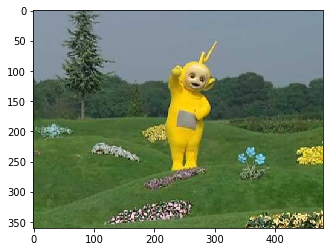

In [9]:
img = Image.open(image_file)
pyplot.imshow(img)
pyplot.show()

In [ ]:
img_deep_dream = DeepDream(img).deepDreamProcess()
pyplot.imshow(img_deep_dream)
pyplot.title("Deep dream image")

In [ ]:
img_deep_dream.save('deepdream.jpg')